In [1]:
import pandas as pd
import numpy as np

# Load the cleaned dataset generated from Step 2
df = pd.read_csv("../data/processed/reported_reviews_clean.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head(3)


Shape: (32206, 10)
Columns: ['object_id', 'complex_id', 'vote_reason_id', 'reason', 'date_created', 'date_updated', 'review_text', 'text_len', 'day_of_week', 'hour_of_day']


,object_id,complex_id,vote_reason_id,reason,date_created,date_updated,review_text,text_len,day_of_week,hour_of_day
0,112885551,9.723591e+14,6,"It contains threats, lewdness or hate speech",2021-09-27 13:52:34,2021-09-27 13:52:34,Initially I was excited about moving to Settle...,1052.0,Monday,13.0
1,112795026,9.199332e+18,1,It's for the wrong community,2021-08-23 17:11:15,2021-08-23 17:11:15,Love my apartment and the staff here. I like t...,209.0,Monday,17.0
2,112795026,9.199332e+18,1,It's for the wrong community,2021-08-23 16:55:42,2021-08-23 16:55:42,Love my apartment and the staff here. I like t...,209.0,Monday,16.0


In [2]:
# Strict cleaning before stratified split

# 1) Keep only rows with non-empty text and label
mask = (
    df["review_text"].astype(str).str.strip().ne("") &
    df["reason"].astype(str).str.strip().ne("")
)
df_clean = df.loc[mask].copy()

# 2) Normalize label strings
df_clean["reason"] = df_clean["reason"].astype(str).str.strip()

# 3) Drop rare classes (stratify requires >=2 in each split; keep a safe minimum)
vc = df_clean["reason"].value_counts()
keep = vc[vc >= 5].index  # adjust threshold if needed
df_clean = df_clean[df_clean["reason"].isin(keep)].copy()

# 4) Final sanity checks
print("NaN in reason:", df_clean["reason"].isna().sum())
print("NaN in review_text:", df_clean["review_text"].isna().sum())
print("Classes:", df_clean["reason"].nunique())
print(df_clean["reason"].value_counts().tail())  # see the smallest classes

# 5) Define X, y and split
from sklearn.model_selection import train_test_split

X = df_clean["review_text"]
y = df_clean["reason"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train), len(X_test), y.nunique()


NaN in reason: 0
NaN in review_text: 16
Classes: 10
reason
It's for the wrong community                             2017
It contains irrelevant information that is not useful    1798
It contains promotional materials                        1135
It's influenced by COVID-19 / conavirus                   213
nan                                                        16
Name: count, dtype: int64


(25756, 6440, 10)

In [3]:
import re
import string

PUNCT = set(string.punctuation)

def basic_clean(text: str) -> str:
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def count_upper_words(text: str) -> int:
    # words with >=2 letters and all uppercase (BE CAREFUL, OK, USA...)
    return sum(1 for w in re.findall(r"[A-Za-z]{2,}", text) if w.isupper())

def count_exclamation(text: str) -> int:
    return text.count("!")

def count_punctuation(text: str) -> int:
    return sum(1 for ch in text if ch in PUNCT)


In [4]:
def build_numeric_features(series: pd.Series) -> pd.DataFrame:
    s = series.fillna("")
    return pd.DataFrame({
        "text_len": s.str.len(),
        "upper_words": s.apply(count_upper_words),
        "exclamation": s.apply(count_exclamation),
        "punctuation": s.apply(count_punctuation),
    })

Xnum_train = build_numeric_features(X_train)
Xnum_test  = build_numeric_features(X_test)

Xnum_train.describe().T


,count,mean,std,min,25%,50%,75%,max
text_len,25756.0,978.053114,993.396645,0.0,337.0,642.5,1226.0,14345.0
upper_words,25756.0,4.806841,21.157633,0.0,0.0,0.0,2.0,601.0
exclamation,25756.0,1.850054,5.188442,0.0,0.0,0.0,2.0,331.0
punctuation,25756.0,29.464474,35.537602,0.0,9.0,18.0,37.0,606.0


In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        return pd.Series(X).fillna("").map(basic_clean).values

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# We will pass a DataFrame with two columns: "text" and numeric features
def make_joint_frame(text_series, num_df):
    d = num_df.copy()
    d = d.reset_index(drop=True)
    d["text"] = text_series.reset_index(drop=True)
    return d

Xtrain_joint = make_joint_frame(X_train, Xnum_train)
Xtest_joint  = make_joint_frame(X_test,  Xnum_test)

text_tfidf = Pipeline([
    ("clean", TextCleaner()),
    ("tfidf", TfidfVectorizer(max_features=7000, ngram_range=(1,2), stop_words="english"))
])

preproc = ColumnTransformer(
    transformers=[
        ("text", text_tfidf, "text"),
        ("num", "passthrough", ["text_len","upper_words","exclamation","punctuation"])
    ],
    remainder="drop"
)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

models = {
    "lr_tfidf_num": Pipeline([
        ("pre", preproc),
        ("clf", LogisticRegression(max_iter=400, class_weight="balanced"))
    ]),
    "svm_tfidf_num": Pipeline([
        ("pre", preproc),
        ("clf", LinearSVC())
    ]),
}
list(models.keys())


['lr_tfidf_num', 'svm_tfidf_num']

In [7]:
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate(model_name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    ypred = model.predict(Xte)
    print(f"=== {model_name} ===")
    print(classification_report(yte, ypred, digits=3, zero_division=0))
    return {
        "name": model_name,
        "macro_f1": f1_score(yte, ypred, average="macro"),
        "weighted_f1": f1_score(yte, ypred, average="weighted"),
        "model": model,
        "y_pred": ypred
    }


In [8]:
results = []
for name, mdl in models.items():
    res = evaluate(name, mdl, Xtrain_joint, y_train, Xtest_joint, y_test)
    results.append(res)

# Sort by macro F1
sorted([(r["name"], round(r["macro_f1"], 3), round(r["weighted_f1"], 3)) for r in results],
       key=lambda x: x[1], reverse=True)


/Users/tiffanytseng/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== lr_tfidf_num ===
                                                                precision    recall  f1-score   support

                                 It contains false information      0.311     0.021     0.039      1359
         It contains irrelevant information that is not useful      0.058     0.064     0.061       360
                             It contains promotional materials      0.057     0.828     0.107       227
                  It contains threats, lewdness or hate speech      0.264     0.161     0.200      1109
               It violates ApartmentRatings' privacy standards      0.222     0.200     0.210       876
It was posted by a competitor, ex-employee or evicted resident      0.254     0.036     0.063      1234
        It was posted by someone affiliated with the community      0.138     0.069     0.092       826
                                  It's for the wrong community      0.082     0.045     0.058       403
                       It's influenced by 

[('svm_tfidf_num', 0.427, 0.407), ('lr_tfidf_num', 0.186, 0.106)]

In [9]:
# Make Logistic Regression converge more reliably (minimal changes)
models["lr_tfidf_num"].set_params(
    clf__solver="saga",
    clf__max_iter=6000,   # was 3000
    clf__tol=1e-3,        # relax tolerance a bit (default 1e-4)
    clf__C=0.5            # stronger regularization than 1.0
)

res = evaluate(
    "lr_tfidf_num_retrained_v2",
    models["lr_tfidf_num"],
    Xtrain_joint, y_train,
    Xtest_joint, y_test
)
res["macro_f1"], res["weighted_f1"]


=== lr_tfidf_num_retrained_v2 ===
                                                                precision    recall  f1-score   support

                                 It contains false information      0.000     0.000     0.000      1359
         It contains irrelevant information that is not useful      0.121     0.067     0.086       360
                             It contains promotional materials      0.000     0.000     0.000       227
                  It contains threats, lewdness or hate speech      0.217     0.344     0.266      1109
               It violates ApartmentRatings' privacy standards      0.143     0.734     0.240       876
It was posted by a competitor, ex-employee or evicted resident      0.000     0.000     0.000      1234
        It was posted by someone affiliated with the community      0.000     0.000     0.000       826
                                  It's for the wrong community      0.000     0.000     0.000       403
                       It's i

(0.15918642887853435, 0.08369774386618702)

Best: svm_tfidf_num Macro-F1: 0.4265764097626761


<Figure size 1000x800 with 0 Axes>

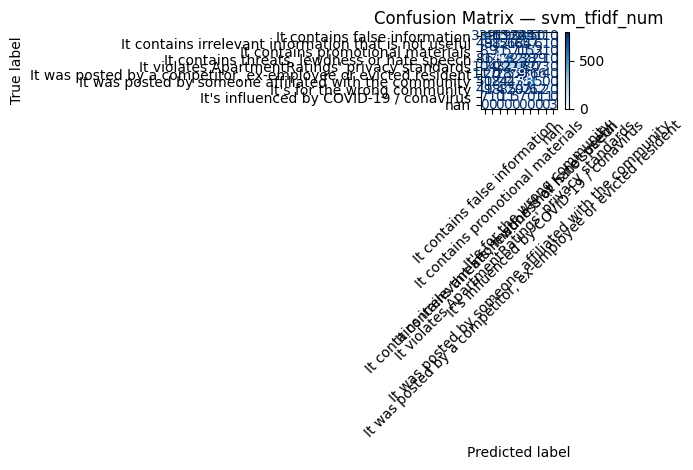

✅ Saved: ../app/model_expanded.pkl


In [10]:
import os, joblib
best = max(results, key=lambda r: r["macro_f1"])
print("Best:", best["name"], "Macro-F1:", best["macro_f1"])

plt.figure(figsize=(10,8))
ConfusionMatrixDisplay.from_predictions(y_test, best["y_pred"], xticks_rotation=45, cmap="Blues")
plt.title(f"Confusion Matrix — {best['name']}")
plt.tight_layout()
plt.show()

os.makedirs("../app", exist_ok=True)
joblib.dump(best["model"], "../app/model_expanded.pkl")
print("✅ Saved:", "../app/model_expanded.pkl")


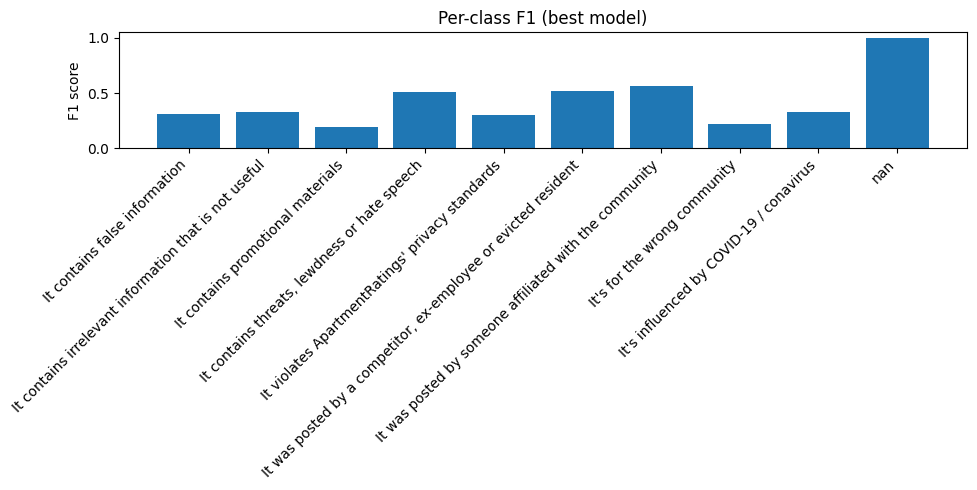

,label,precision,recall,f1,support
9,nan,1.000000,1.000000,1.000000,3
6,It was posted by someone affiliated with the c...,0.466932,0.709443,0.563191,826
5,"It was posted by a competitor, ex-employee or ...",0.430578,0.645867,0.516694,1234
3,"It contains threats, lewdness or hate speech",0.447678,0.582507,0.506270,1109
8,It's influenced by COVID-19 / conavirus,0.458333,0.255814,0.328358,43
1,It contains irrelevant information that is not...,0.401639,0.272222,0.324503,360
0,It contains false information,0.419554,0.249448,0.312875,1359
4,It violates ApartmentRatings' privacy standards,0.392015,0.246575,0.302733,876
7,It's for the wrong community,0.366864,0.153846,0.216783,403
2,It contains promotional materials,0.336957,0.136564,0.194357,227


In [11]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

labels = sorted(y_test.unique())
prec, rec, f1, support = precision_recall_fscore_support(y_test, best["y_pred"], labels=labels, zero_division=0)

plt.figure(figsize=(10,5))
plt.bar(labels, f1)
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1 score")
plt.title("Per-class F1 (best model)")
plt.tight_layout()
plt.show()

pd.DataFrame({"label": labels, "precision": prec, "recall": rec, "f1": f1, "support": support}).sort_values("f1", ascending=False).head(10)


In [12]:
# Re-train Logistic Regression with more stable settings
models["lr_tfidf_num"].set_params(
    clf__solver="saga",     # more stable for sparse, high-dimensional TF-IDF data
    clf__max_iter=3000,     # increase iterations to ensure convergence
    clf__C=1.0              # regularization strength (lower = stronger)
)

# Re-train and evaluate
res = evaluate(
    "lr_tfidf_num_retrained",
    models["lr_tfidf_num"],
    Xtrain_joint, y_train,
    Xtest_joint, y_test
)

# Display macro and weighted F1 scores
res["macro_f1"], res["weighted_f1"]


=== lr_tfidf_num_retrained ===
                                                                precision    recall  f1-score   support

                                 It contains false information      0.000     0.000     0.000      1359
         It contains irrelevant information that is not useful      0.121     0.067     0.086       360
                             It contains promotional materials      0.000     0.000     0.000       227
                  It contains threats, lewdness or hate speech      0.217     0.344     0.266      1109
               It violates ApartmentRatings' privacy standards      0.143     0.734     0.240       876
It was posted by a competitor, ex-employee or evicted resident      0.000     0.000     0.000      1234
        It was posted by someone affiliated with the community      0.000     0.000     0.000       826
                                  It's for the wrong community      0.000     0.000     0.000       403
                       It's infl

(0.15918642887853435, 0.08369774386618702)

In [13]:
# Stable GridSearch for Logistic Regression on high-dimensional TF-IDF

import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.base import clone
warnings.filterwarnings("ignore", category=ConvergenceWarning)  # optional: silence convergence logs

# 1) make a stable base estimator (saga + more iterations)
stable_est = clone(models["lr_tfidf_num"])
stable_est.set_params(
    clf__solver="saga",   # better for sparse high-dimensional features
    clf__max_iter=3000,   # give enough iterations
    clf__C=1.0            # regularization strength
)

# 2) your search space (unchanged)
grid = {
    "pre__text__tfidf__max_features": [5000, 7000, 10000],
    "pre__text__tfidf__ngram_range": [(1,1), (1,2)]
}

# 3) run grid search
from sklearn.model_selection import GridSearchCV
grid_mdl = GridSearchCV(
    estimator=stable_est,     # ← use the stable estimator here
    param_grid=grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=1,
    verbose=1
)

grid_mdl.fit(Xtrain_joint, y_train)
print("Best params:", grid_mdl.best_params_, "Best f1_macro:", grid_mdl.best_score_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'pre__text__tfidf__max_features': 10000, 'pre__text__tfidf__ngram_range': (1, 1)} Best f1_macro: 0.15927382637260687
